# EDA - Who cut my card? First Approach

## Setup

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml, time, sys, os

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  
sns.set_style("darkgrid")

DATASET = "Churn_Kaggle"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = True


In [49]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)


## Load Dataset

In [50]:
customers_train = pd.read_csv(f"{ROOT}/orig/customers_train.csv", 
                        parse_dates=["Start_Date"])

customers_test = pd.read_csv(f"{ROOT}/orig/customers_test.csv", 
                        parse_dates=["Start_Date"])

print(f"Train:{customers_train.shape}", f"Test:{customers_test.shape}")
customers_train.head()


Train:(6577, 15) Test:(3542, 14)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income
0,797197508,No,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,F,Graduate,Married,2,Less than €30K
1,812854728,No,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.0,F,Second level,Single,5,Less than €30K
2,768000743,No,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.0,F,Second level,Single,2,Less than €30K
3,722161439,No,Silver,2020-08-01,3,4663.0,0,4663.0,0.000,41.0,F,Graduate,NaN,2,€30K - €50K
4,759029725,No,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.0,F,Second level,Single,1,Less than €30K


In [51]:

accounts_train = pd.read_csv(f"{ROOT}/orig/accounts_train.csv")
accounts_test = pd.read_csv(f"{ROOT}/orig/accounts_test.csv")
print(f"Train:{accounts_train.shape}", f"Test:{accounts_test.shape}")
accounts_train.head()


Train:(25012, 2) Test:(13575, 2)


,Customer,Account
0,828247016,Investment
1,828247016,Current
2,828247016,Credit Card
3,828247016,On Demand Deposit
4,828247016,Mortgage


In [52]:

transactions_train = pd.read_csv(f"{ROOT}/orig/transactions_train.csv",
                                 parse_dates=["Date"])
transactions_test = pd.read_csv(f"{ROOT}/orig/transactions_test.csv",
                                 parse_dates=["Date"])
print(f"Train:{transactions_train.shape}", f"Test:{transactions_test.shape}")
transactions_train.head()

Train:(514611, 3) Test:(227447, 3)


,Customer,Date,Amount
0,828247016,2022-03-01,70.94
1,828247016,2022-02-21,52.16
2,828247016,2022-02-19,67.03
3,828247016,2022-02-19,48.24
4,828247016,2022-05-20,10.97


In [53]:
target = "Churn"

## Clean

In [54]:
def eda_cat(df, feature, target, save=False, show=True):

    # convert NaN to "NaN"
    if df[feature].isna().sum()>0:
        df[feature] = df[feature].cat.add_categories("NaN").fillna("NaN")

    # create a 1x2 subplot
    fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)

    # bar plot to show counts
    df_ct = pd.crosstab(df[feature], df[target], dropna=False, margins=True)[:-1]
    df_ct.sort_values("All", ascending=False, inplace=True)
    df_ct['All'].plot(kind='barh', stacked=True, ax=axs[0])
    axs[0].set_title("counts")

    # normalised stacked barplot to show breakdown
    df_ct = df_ct.iloc[:,:-1].div(df_ct.All, axis=0)
    df_ct.plot(kind='barh', stacked=True, ax=axs[1])
    axs[1].legend(bbox_to_anchor=(1,1), facecolor='gray', framealpha=1)
    axs[1].set_title(f"breakdown wrt {target}")

    plt.suptitle(f"Feature {feature} - Count plot and breakdown wrt {target}")

    if save:
        filename = save if type(save)==str else feature
        plt.savefig(f"output/{filename}.png", bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [55]:
print(f"Train:\n{transactions_train.isna().sum()}")

Train:
Customer    0
Date        0
Amount      0
dtype: int64


In [56]:
accounts_train.isna().sum()
print(f"Train:\n{accounts_train.isna().sum()}")

Train:
Customer    0
Account     0
dtype: int64


In [57]:
customers_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6577 entries, 0 to 6576
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   6577 non-null   int64         
 1   Churn                      6556 non-null   object        
 2   Card                       6577 non-null   object        
 3   Start_Date                 6577 non-null   datetime64[ns]
 4   Customer_Service_Calls     6577 non-null   int64         
 5   Credit_Limit               6577 non-null   float64       
 6   Total_Revolving_Balance    6577 non-null   int64         
 7   Average_Open_To_Buy        6577 non-null   float64       
 8   Average_Utilisation_Ratio  6577 non-null   float64       
 9   Age                        6312 non-null   float64       
 10  Gender                     6577 non-null   object        
 11  Education                  6577 non-null   object        
 12  Marita

In [58]:
customers_train.isna().sum()

Customer                       0
Churn                         21
Card                           0
Start_Date                     0
Customer_Service_Calls         0
Credit_Limit                   0
Total_Revolving_Balance        0
Average_Open_To_Buy            0
Average_Utilisation_Ratio      0
Age                          265
Gender                         0
Education                      0
Marital_Status               475
Dependents                     0
Income                         0
dtype: int64

In [59]:
customers_train.nunique()

Customer                     6577
Churn                           2
Card                            4
Start_Date                     44
Customer_Service_Calls          7
Credit_Limit                 4499
Total_Revolving_Balance      1791
Average_Open_To_Buy          4938
Average_Utilisation_Ratio     934
Age                            43
Gender                          2
Education                       7
Marital_Status                  3
Dependents                      6
Income                          6
dtype: int64

### Missing values - Churn
* Drop all customers from the 3 Tables which we dont have churn value

In [60]:
df_drop = customers_train.copy()
df_drop = df_drop[df_drop.Churn.isna()]

In [61]:
mask = customers_train.Customer.isin(df_drop.Customer)
customers_train.drop(customers_train[mask].index, inplace=True)
customers_train[target] = pd.Categorical(customers_train[target].astype(str))
print(customers_train.shape)

(6556, 15)


In [62]:
mask = accounts_train.Customer.isin(df_drop.Customer)
accounts_train.drop(accounts_train[mask].index, inplace=True)
print(accounts_train.shape)

(24937, 2)


In [63]:
mask = transactions_train.Customer.isin(df_drop.Customer)
transactions_train.drop(transactions_train[mask].index, inplace=True)
print(transactions_train.shape)

(513247, 3)


### Total_Revolving_Balance    

In [64]:
customers_train["Total_Revolving_Balance"] = customers_train["Total_Revolving_Balance"].astype(float)

In [65]:
customers_test["Total_Revolving_Balance"] = customers_test["Total_Revolving_Balance"].astype(float)

### Marital

In [66]:
print(f"Train: {customers_train.Marital_Status.isna().sum()} /",f"Test: {customers_test.Marital_Status.isna().sum()}")

Train: 475 / Test: 0


In [67]:
criteria = customers_train.Marital_Status.isna()
customers_train.loc[criteria, "Marital_Status"] = "NaN"

In [68]:
customers_train["Marital_Status"] = pd.Categorical(customers_train["Marital_Status"].astype(str))
customers_test["Marital_Status"] = pd.Categorical(customers_test["Marital_Status"].astype(str))

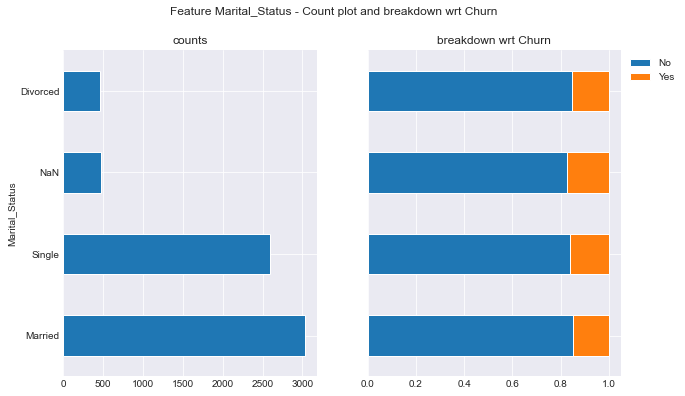

In [69]:
eda_cat(customers_train,"Marital_Status",target)

### Card

In [70]:
feature = "Card"
card_order = ['Silver', 'Gold', 'Platinum', 'Black']

In [71]:
customers_train[feature] = customers_train[feature].map(lambda x: card_order.index(x))
customers_test[feature] = customers_test[feature].map(lambda x: card_order.index(x))

### Education

In [72]:
feature = "Education"
edu_order = ['Unknown', 'Primary level', 'Second level','Graduate', 'MSc','Post LC', 'PhD']

In [73]:
customers_train[feature] = customers_train[feature].map(lambda x: edu_order.index(x))
customers_test[feature] = customers_test[feature].map(lambda x: edu_order.index(x))

### Gender

In [74]:
customers_train["Gender"] = pd.Categorical(customers_train["Gender"].astype(str))
customers_test["Gender"] = pd.Categorical(customers_test["Gender"].astype(str))

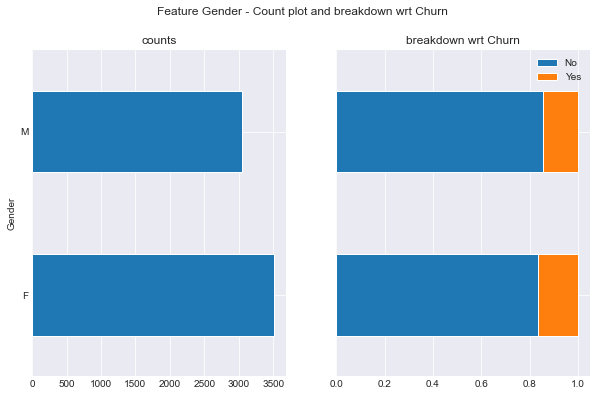

In [75]:
eda_cat(customers_train,"Gender",target)

### Income

In [76]:
feature = "Income"
inc_order = ['Unknown','Less than €30K','€30K - €50K', '€50K - €80K', '€80K - €100K', '€100K +']

In [77]:
customers_train[feature] = customers_train[feature].map(lambda x: inc_order.index(x))
customers_test[feature] = customers_test[feature].map(lambda x: inc_order.index(x))

### Start_Date

In [78]:
latest_date = customers_train.Start_Date.max()
customers_train['Days'] = (latest_date - customers_train['Start_Date']).dt.days.astype(float)

In [79]:
latest_date = customers_test.Start_Date.max()
customers_test['Days'] = (latest_date - customers_test['Start_Date']).dt.days.astype(float)

### Account type

In [80]:
accounts_train["Account"] = pd.Categorical(accounts_train["Account"].astype(str))
accounts_test["Account"] = pd.Categorical(accounts_test["Account"].astype(str))


In [81]:
def myLen(x):
    if len(x): return 1
    return 0

In [82]:
accounts_train = accounts_train.pivot_table(index='Customer', columns='Account', aggfunc=myLen, fill_value=0)
accounts_train = accounts_train.astype('category')
accounts_train = accounts_train.replace({0:"No",1:"Yes"})

In [83]:
accounts_test = accounts_test.pivot_table(index='Customer', columns='Account', aggfunc=myLen, fill_value=0)
accounts_test = accounts_test.astype('category')
accounts_test = accounts_test.replace({0:"No",1:"Yes"})

In [84]:
accounts_train.reset_index(inplace=True)
accounts_train.head()

Account,Customer,Credit Card,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit
0,708115009,Yes,No,No,No,No,No,No,No
1,708117651,Yes,Yes,No,No,No,No,No,No
2,708163600,Yes,Yes,No,No,No,No,No,Yes
3,708166361,Yes,Yes,Yes,No,No,No,Yes,No
4,708169780,Yes,Yes,No,No,No,No,No,No


In [85]:
accounts_test.reset_index(inplace=True)
accounts_test.head()

Account,Customer,Credit Card,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit
0,708182832,Yes,Yes,Yes,Yes,No,No,No,No
1,708240660,Yes,Yes,Yes,Yes,No,Yes,No,No
2,708249778,Yes,Yes,No,Yes,No,No,Yes,No
3,708259785,Yes,Yes,Yes,No,No,No,No,No
4,708264579,Yes,Yes,Yes,Yes,Yes,No,No,Yes


### Transactions Parse

In [86]:
def transactions_summary(df):
    transactions_summary = df.groupby('Customer').agg({
    'Date': ['count'],
    'Amount': ['max', 'min', 'mean','std', 'sum']
})
    transactions_summary = transactions_summary.rename(columns={
    'count': 'Num_Transaction',
    'max': 'Max_Transaction',
    'min': 'Min_Transaction',
    'mean': 'Mean_Transaction',
    'std': 'Std_Transaction',
    'sum': 'Sum_Transaction',
    
})
    transactions_summary.columns = transactions_summary.columns.droplevel(level=[0])
    
    return transactions_summary
    

In [87]:
transactions_summary_train = transactions_summary(transactions_train)
print(transactions_summary_train.shape)
transactions_summary_train.head()

(7858, 6)


,Num_Transaction,Max_Transaction,Min_Transaction,Mean_Transaction,Std_Transaction,Sum_Transaction
Customer,,,,,,
708115009,36,279.64,6.82,52.416389,59.107430,1886.99
708117651,86,729.52,3.51,86.046860,106.583822,7400.03
708163600,104,610.34,10.42,127.884519,120.837902,13299.99
708166361,72,153.54,10.50,57.055417,37.381339,4107.99
708169780,78,544.69,6.72,58.204487,79.450143,4539.95


In [88]:
transactions_summary_test = transactions_summary(transactions_test)

## Merge

In [89]:
def myMerge(df1,df2,df3):
    merge_tmp = pd.merge(df1, df2, on='Customer', how='left')
    df_merge = pd.merge(merge_tmp, df3, on='Customer', how='left')
    df_merge.columns = [c.replace(" ", "_").replace("'", "").replace("?", "") for c in df_merge.columns]
    return df_merge

In [90]:
df_train = myMerge(customers_train,accounts_train,transactions_summary_train)
df_train.dropna(inplace = True)
print(df_train.shape)
df_train.head()

(6291, 30)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Days,Credit_Card,Current,Deposit,Investment,Joint,Loan,Mortgage,On_Demand_Deposit,Num_Transaction,Max_Transaction,Min_Transaction,Mean_Transaction,Std_Transaction,Sum_Transaction
0,797197508,No,0,2020-06-01,1,2315.0,1565.0,750.0,0.676,48.0,F,3,Married,2,1,548.0,Yes,Yes,Yes,Yes,No,No,Yes,No,90,342.82,8.59,53.644000,51.087679,4827.96
1,812854728,No,0,2020-01-01,1,7645.0,2076.0,5569.0,0.272,58.0,F,2,Single,5,1,700.0,Yes,No,No,No,No,No,No,No,75,1296.47,5.89,102.799600,181.396165,7709.97
2,768000743,No,0,2020-01-01,2,6394.0,0.0,6394.0,0.000,55.0,F,2,Single,2,1,700.0,Yes,Yes,No,No,No,No,No,No,69,279.84,3.97,50.290725,52.551327,3470.06
3,722161439,No,0,2020-08-01,3,4663.0,0.0,4663.0,0.000,41.0,F,3,NaN,2,2,487.0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,81,317.30,9.96,47.296420,50.063738,3831.01
4,759029725,No,0,2021-02-01,4,1879.0,1486.0,393.0,0.791,37.0,F,2,Single,1,1,303.0,Yes,Yes,Yes,Yes,No,No,Yes,No,88,237.55,5.45,59.114091,60.445166,5202.04


In [91]:
df_test = myMerge(customers_test,accounts_test,transactions_summary_test)
df_test.dropna(inplace = True)
print(df_test.shape)
df_test.head()

(3542, 29)


,Customer,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Days,Credit_Card,Current,Deposit,Investment,Joint,Loan,Mortgage,On_Demand_Deposit,Num_Transaction,Max_Transaction,Min_Transaction,Mean_Transaction,Std_Transaction,Sum_Transaction
0,774663629,1,2020-01-01,2,29663.0,1743.0,27920.0,0.059,51,M,3,Single,3,3,700.0,Yes,Yes,Yes,No,No,No,No,No,93,1176.28,10.82,157.397849,177.297431,14638.00
1,720420396,0,2020-11-01,2,2032.0,1195.0,837.0,0.588,45,F,0,Divorced,3,2,395.0,Yes,No,No,No,No,No,No,No,80,399.76,3.28,55.987125,60.871741,4478.97
2,815283379,0,2020-01-01,1,17268.0,1197.0,16071.0,0.069,57,M,3,Single,3,5,700.0,Yes,Yes,No,No,No,No,No,No,90,213.94,3.79,45.300111,46.328322,4077.01
3,764861610,0,2020-05-01,3,2264.0,0.0,2264.0,0.000,38,F,1,Single,2,1,579.0,Yes,Yes,Yes,Yes,No,Yes,No,No,28,186.81,8.67,43.000714,44.238825,1204.02
4,742798818,0,2020-01-01,1,2192.0,1464.0,728.0,0.668,45,F,4,Unknown,4,1,700.0,Yes,No,Yes,No,Yes,Yes,Yes,Yes,89,260.42,6.95,55.112697,55.664159,4905.03


### Age

In [92]:
df_train['Age'] = df_train['Age'].astype(int)
df_test['Age'] = df_test['Age'].astype(int)

<AxesSubplot:xlabel='Churn', ylabel='Sum_Transaction'>

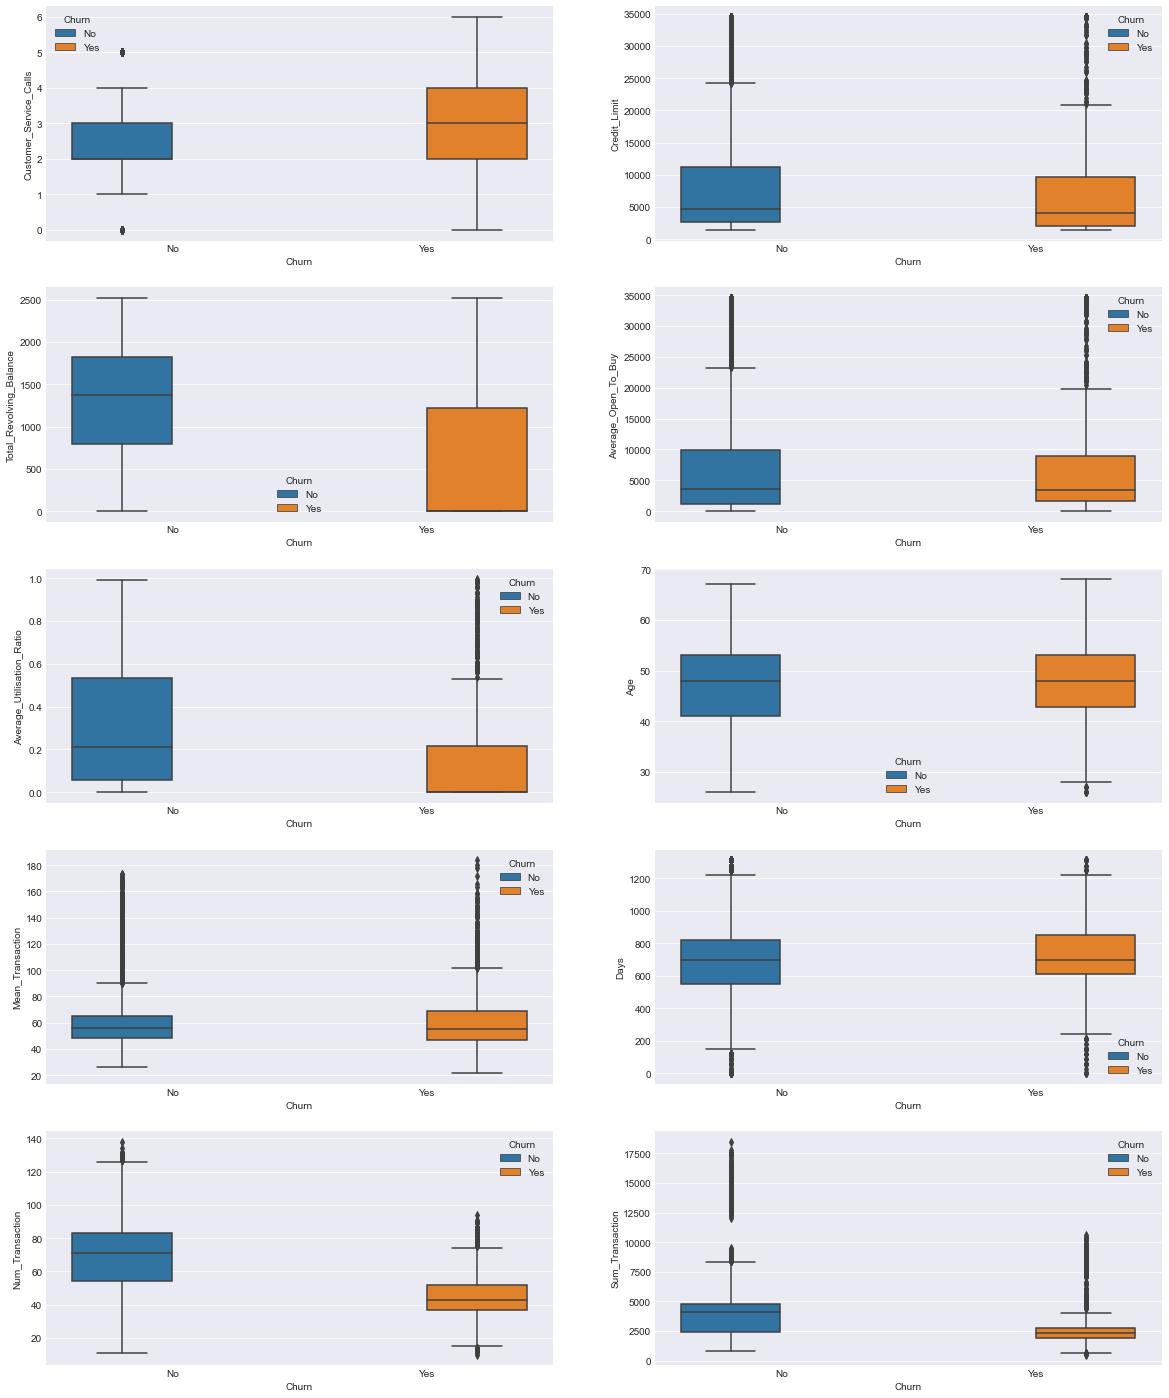

In [93]:
fig, axarr = plt.subplots(5, 2, figsize=(20, 25))
sns.boxplot(y='Customer_Service_Calls',x = target, hue = target,data = df_train, ax=axarr[0][0])
sns.boxplot(y='Credit_Limit',x = target, hue = target,data = df_train , ax=axarr[0][1])
sns.boxplot(y='Total_Revolving_Balance',x = target, hue = target,data = df_train, ax=axarr[1][0])
sns.boxplot(y='Average_Open_To_Buy',x = target, hue = target,data = df_train, ax=axarr[1][1])
sns.boxplot(y='Average_Utilisation_Ratio',x = target, hue = target,data = df_train, ax=axarr[2][0])
sns.boxplot(y='Age',x = target, hue = target,data = df_train, ax=axarr[2][1])
sns.boxplot(y='Mean_Transaction',x = target, hue = target,data = df_train, ax=axarr[3][0])
sns.boxplot(y='Days',x = target, hue = target,data = df_train , ax=axarr[3][1])
sns.boxplot(y='Num_Transaction',x = target, hue = target,data = df_train, ax=axarr[4][0])
sns.boxplot(y='Sum_Transaction',x = target, hue = target,data = df_train, ax=axarr[4][1])

# Save Dataset 1

In [94]:
df_train.to_pickle(f"{ROOT}/data/df_train.pkl")
df_test.to_pickle(f"{ROOT}/data/df_test.pkl")

# EDA - Who cut my card? Second Approach

## Load Dataset

In [97]:
customers_train = pd.read_csv(f"{ROOT}/orig/customers_train.csv", 
                        parse_dates=["Start_Date"])

customers_test = pd.read_csv(f"{ROOT}/orig/customers_test.csv", 
                        parse_dates=["Start_Date"])

print(f"Train:{customers_train.shape}", f"Test:{customers_test.shape}")
customers_train.head()


Train:(6577, 15) Test:(3542, 14)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income
0,797197508,No,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,F,Graduate,Married,2,Less than €30K
1,812854728,No,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.0,F,Second level,Single,5,Less than €30K
2,768000743,No,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.0,F,Second level,Single,2,Less than €30K
3,722161439,No,Silver,2020-08-01,3,4663.0,0,4663.0,0.000,41.0,F,Graduate,NaN,2,€30K - €50K
4,759029725,No,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.0,F,Second level,Single,1,Less than €30K


In [98]:

accounts_train = pd.read_csv(f"{ROOT}/orig/accounts_train.csv")
accounts_test = pd.read_csv(f"{ROOT}/orig/accounts_test.csv")
print(f"Train:{accounts_train.shape}", f"Test:{accounts_test.shape}")
accounts_train.head()


Train:(25012, 2) Test:(13575, 2)


,Customer,Account
0,828247016,Investment
1,828247016,Current
2,828247016,Credit Card
3,828247016,On Demand Deposit
4,828247016,Mortgage


In [99]:

transactions_train = pd.read_csv(f"{ROOT}/orig/transactions_train.csv",
                                 parse_dates=["Date"])
transactions_test = pd.read_csv(f"{ROOT}/orig/transactions_test.csv",
                                 parse_dates=["Date"])
print(f"Train:{transactions_train.shape}", f"Test:{transactions_test.shape}")
transactions_train.head()

Train:(514611, 3) Test:(227447, 3)


,Customer,Date,Amount
0,828247016,2022-03-01,70.94
1,828247016,2022-02-21,52.16
2,828247016,2022-02-19,67.03
3,828247016,2022-02-19,48.24
4,828247016,2022-05-20,10.97


In [100]:
target = "Churn"

## Clean

In [101]:
def eda_cat(df, feature, target, save=False, show=True):

    # convert NaN to "NaN"
    if df[feature].isna().sum()>0:
        df[feature] = df[feature].cat.add_categories("NaN").fillna("NaN")

    # create a 1x2 subplot
    fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey=True)

    # bar plot to show counts
    df_ct = pd.crosstab(df[feature], df[target], dropna=False, margins=True)[:-1]
    df_ct.sort_values("All", ascending=False, inplace=True)
    df_ct['All'].plot(kind='barh', stacked=True, ax=axs[0])
    axs[0].set_title("counts")

    # normalised stacked barplot to show breakdown
    df_ct = df_ct.iloc[:,:-1].div(df_ct.All, axis=0)
    df_ct.plot(kind='barh', stacked=True, ax=axs[1])
    axs[1].legend(bbox_to_anchor=(1,1), facecolor='gray', framealpha=1)
    axs[1].set_title(f"breakdown wrt {target}")

    plt.suptitle(f"Feature {feature} - Count plot and breakdown wrt {target}")

    if save:
        filename = save if type(save)==str else feature
        plt.savefig(f"output/{filename}.png", bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

In [102]:
print(f"Train:\n{transactions_train.isna().sum()}")

Train:
Customer    0
Date        0
Amount      0
dtype: int64


In [103]:
accounts_train.isna().sum()
print(f"Train:\n{accounts_train.isna().sum()}")

Train:
Customer    0
Account     0
dtype: int64


In [104]:
customers_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6577 entries, 0 to 6576
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   6577 non-null   int64         
 1   Churn                      6556 non-null   object        
 2   Card                       6577 non-null   object        
 3   Start_Date                 6577 non-null   datetime64[ns]
 4   Customer_Service_Calls     6577 non-null   int64         
 5   Credit_Limit               6577 non-null   float64       
 6   Total_Revolving_Balance    6577 non-null   int64         
 7   Average_Open_To_Buy        6577 non-null   float64       
 8   Average_Utilisation_Ratio  6577 non-null   float64       
 9   Age                        6312 non-null   float64       
 10  Gender                     6577 non-null   object        
 11  Education                  6577 non-null   object        
 12  Marita

In [105]:
customers_train.isna().sum()

Customer                       0
Churn                         21
Card                           0
Start_Date                     0
Customer_Service_Calls         0
Credit_Limit                   0
Total_Revolving_Balance        0
Average_Open_To_Buy            0
Average_Utilisation_Ratio      0
Age                          265
Gender                         0
Education                      0
Marital_Status               475
Dependents                     0
Income                         0
dtype: int64

In [106]:
customers_train.nunique()

Customer                     6577
Churn                           2
Card                            4
Start_Date                     44
Customer_Service_Calls          7
Credit_Limit                 4499
Total_Revolving_Balance      1791
Average_Open_To_Buy          4938
Average_Utilisation_Ratio     934
Age                            43
Gender                          2
Education                       7
Marital_Status                  3
Dependents                      6
Income                          6
dtype: int64

### Missing values - Churn

In [107]:
df_drop = customers_train.copy()
df_drop = df_drop[df_drop.Churn.isna()]

In [108]:
mask = customers_train.Customer.isin(df_drop.Customer)
customers_train.drop(customers_train[mask].index, inplace=True)
customers_train[target] = pd.Categorical(customers_train[target].astype(str))
print(customers_train.shape)

(6556, 15)


In [109]:
mask = accounts_train.Customer.isin(df_drop.Customer)
accounts_train.drop(accounts_train[mask].index, inplace=True)
print(accounts_train.shape)

(24937, 2)


In [110]:
mask = transactions_train.Customer.isin(df_drop.Customer)
transactions_train.drop(transactions_train[mask].index, inplace=True)
print(transactions_train.shape)

(513247, 3)


### Total_Revolving_Balance    

In [111]:
customers_train["Total_Revolving_Balance"] = customers_train["Total_Revolving_Balance"].astype(float)

In [112]:
customers_test["Total_Revolving_Balance"] = customers_test["Total_Revolving_Balance"].astype(float)

### Age

In [113]:
customers_train['Age'].replace(np.nan,customers_train.Age.median(), inplace=True)
customers_test['Age'].replace(np.nan,customers_test.Age.median(), inplace=True)

In [114]:
customers_train['Age'] = customers_train['Age'].astype(int)
customers_test['Age'] = customers_test['Age'].astype(int)

### Marital

In [115]:
feature = "Marital_Status"
order = ['Divorced' , 'Married' , 'Single']

In [116]:
customers_train[feature].replace(['Unknown',np.nan], 'Married', inplace=True)
customers_test[feature].replace(['Unknown',np.nan], 'Married', inplace=True)

In [117]:
customers_train[feature] = customers_train[feature].map(lambda x: order.index(x))
customers_test[feature] = customers_test[feature].map(lambda x: order.index(x))

### Card

In [118]:
feature = "Card"
order = ['Silver','Gold','Platinum', 'Black']

In [119]:
customers_train[feature] = customers_train[feature].map(lambda x: order.index(x))
customers_test[feature] = customers_test[feature].map(lambda x: order.index(x))

### Education

In [120]:
feature = "Education"
order = ['Primary level', 'Second level','Graduate', 'MSc','Post LC', 'PhD']

In [121]:
customers_train[feature].replace('Unknown', 'Graduate', inplace=True)
customers_test[feature].replace('Unknown', 'Graduate', inplace=True)

In [122]:
customers_train[feature] = customers_train[feature].map(lambda x: order.index(x))
customers_test[feature] = customers_test[feature].map(lambda x: order.index(x))

### Gender

In [123]:
customers_train["Gender"] = pd.Categorical(customers_train["Gender"].astype(str))
customers_test["Gender"] = pd.Categorical(customers_test["Gender"].astype(str))

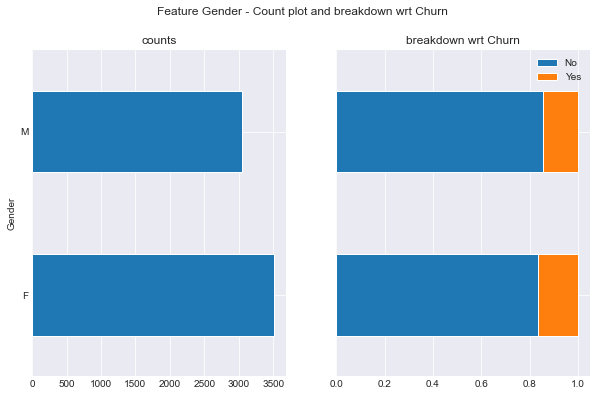

In [124]:
eda_cat(customers_train,"Gender",target)

### Income

In [125]:
feature = "Income"
order = ['Less than €30K','€30K - €50K', '€50K - €80K', '€80K - €100K', '€100K +']

In [126]:
customers_train[feature].replace('Unknown', 'Less than €30K', inplace=True)
customers_test[feature].replace('Unknown', 'Less than €30K', inplace=True)

In [127]:
customers_train[feature] = customers_train[feature].map(lambda x: order.index(x))
customers_test[feature] = customers_test[feature].map(lambda x: order.index(x))

### Start_Date

In [128]:
latest_date = customers_train.Start_Date.max()
customers_train['Days'] = (latest_date - customers_train['Start_Date']).dt.days.astype(float)+1

In [129]:
customers_test['Days'] = (latest_date - customers_test['Start_Date']).dt.days.astype(float)+1

### Account type

In [130]:
accounts_train["Account"] = pd.Categorical(accounts_train["Account"].astype(str))
accounts_test["Account"] = pd.Categorical(accounts_test["Account"].astype(str))


In [131]:
def myLen(x):
    if len(x): return 1
    return 0

In [132]:
accounts_train = accounts_train.pivot_table(index='Customer', columns='Account', aggfunc=myLen, fill_value=0)
accounts_train = accounts_train.astype('category')

In [133]:
accounts_test = accounts_test.pivot_table(index='Customer', columns='Account', aggfunc=myLen, fill_value=0)
accounts_test = accounts_test.astype('category')

In [134]:
accounts_train.reset_index(inplace=True)
accounts_train.head()

Account,Customer,Credit Card,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit
0,708115009,1,0,0,0,0,0,0,0
1,708117651,1,1,0,0,0,0,0,0
2,708163600,1,1,0,0,0,0,0,1
3,708166361,1,1,1,0,0,0,1,0
4,708169780,1,1,0,0,0,0,0,0


In [135]:
accounts_test.reset_index(inplace=True)
accounts_test.head()

Account,Customer,Credit Card,Current,Deposit,Investment,Joint,Loan,Mortgage,On Demand Deposit
0,708182832,1,1,1,1,0,0,0,0
1,708240660,1,1,1,1,0,1,0,0
2,708249778,1,1,0,1,0,0,1,0
3,708259785,1,1,1,0,0,0,0,0
4,708264579,1,1,1,1,1,0,0,1


### Transactions Parse

In [136]:
def transactions_summary(df):
    df['Transaction_Count'] = df.groupby('Customer')['Customer'].transform('count')

    df['Days_Active'] = (df.groupby('Customer')['Date'].transform('max') - df.groupby('Customer')['Date'].transform('min')).dt.days + 1

    df['Avg_Transactions_Per_Day'] = df['Transaction_Count'] / df['Days_Active']
    
    transactions_summary = df.groupby('Customer').agg({
    'Days_Active' : ['max'],
    'Transaction_Count': ['max'],
    'Avg_Transactions_Per_Day' : ['max'],
    'Amount': ['max', 'min', 'mean','std', 'sum']
    })
    transactions_summary.columns = transactions_summary.columns.droplevel(level=[0])
    transactions_summary.columns = ['Days_Active','Transaction_Count','Avg_Transactions_Per_Day','Max_Transaction','Min_Transaction','Mean_Transaction','Std_Transaction','Sum_Transaction']

    return transactions_summary
    

In [137]:
transactions_summary_train = transactions_summary(transactions_train)
print(transactions_summary_train.shape)
transactions_summary_train.head()

(7858, 8)


,Days_Active,Transaction_Count,Avg_Transactions_Per_Day,Max_Transaction,Min_Transaction,Mean_Transaction,Std_Transaction,Sum_Transaction
Customer,,,,,,,,
708115009,300,36,0.120000,279.64,6.82,52.416389,59.107430,1886.99
708117651,362,86,0.237569,729.52,3.51,86.046860,106.583822,7400.03
708163600,352,104,0.295455,610.34,10.42,127.884519,120.837902,13299.99
708166361,357,72,0.201681,153.54,10.50,57.055417,37.381339,4107.99
708169780,363,78,0.214876,544.69,6.72,58.204487,79.450143,4539.95


In [138]:
transactions_summary_test = transactions_summary(transactions_test)

## Merge

In [139]:
def myMerge(df1,df2,df3):
    merge_tmp = pd.merge(df1, df2, on='Customer', how='left')
    df_merge = pd.merge(merge_tmp, df3, on='Customer', how='left')
    df_merge.columns = [c.replace(" ", "_").replace("'", "").replace("?", "") for c in df_merge.columns]
    return df_merge

In [140]:
df_train = myMerge(customers_train,accounts_train,transactions_summary_train)
print(df_train.shape)
df_train.head()

(6556, 32)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Days,Credit_Card,Current,Deposit,Investment,Joint,Loan,Mortgage,On_Demand_Deposit,Days_Active,Transaction_Count,Avg_Transactions_Per_Day,Max_Transaction,Min_Transaction,Mean_Transaction,Std_Transaction,Sum_Transaction
0,797197508,No,0,2020-06-01,1,2315.0,1565.0,750.0,0.676,48,F,2,1,2,0,549.0,1,1,1,1,0,0,1,0,331,90,0.271903,342.82,8.59,53.644000,51.087679,4827.96
1,812854728,No,0,2020-01-01,1,7645.0,2076.0,5569.0,0.272,58,F,1,2,5,0,701.0,1,0,0,0,0,0,0,0,362,75,0.207182,1296.47,5.89,102.799600,181.396165,7709.97
2,768000743,No,0,2020-01-01,2,6394.0,0.0,6394.0,0.000,55,F,1,2,2,0,701.0,1,1,0,0,0,0,0,0,332,69,0.207831,279.84,3.97,50.290725,52.551327,3470.06
3,722161439,No,0,2020-08-01,3,4663.0,0.0,4663.0,0.000,41,F,2,1,2,1,488.0,1,1,1,1,0,1,1,0,327,81,0.247706,317.30,9.96,47.296420,50.063738,3831.01
4,759029725,No,0,2021-02-01,4,1879.0,1486.0,393.0,0.791,37,F,1,2,1,0,304.0,1,1,1,1,0,0,1,0,359,88,0.245125,237.55,5.45,59.114091,60.445166,5202.04


In [141]:
df_test = myMerge(customers_test,accounts_test,transactions_summary_test)

In [142]:
df_train.nunique()

Customer                     6556
Churn                           2
Card                            4
Start_Date                     44
Customer_Service_Calls          7
Credit_Limit                 4491
Total_Revolving_Balance      1790
Average_Open_To_Buy          4930
Average_Utilisation_Ratio     934
Age                            43
Gender                          2
Education                       6
Marital_Status                  3
Dependents                      6
Income                          5
Days                           44
Credit_Card                     1
Current                         2
Deposit                         2
Investment                      2
Joint                           2
Loan                            2
Mortgage                        2
On_Demand_Deposit               2
Days_Active                   111
Transaction_Count             126
Avg_Transactions_Per_Day     3120
Max_Transaction              6161
Min_Transaction              1016
Mean_Transacti

In [143]:
df_train = df_train.drop(['Credit_Card'], axis=1)
df_test = df_test.drop(['Credit_Card'], axis=1)

### Account

In [144]:
account_types = ['Current', 'Deposit', 'Investment', 'Joint', 'Loan', 'Mortgage', 'On_Demand_Deposit']

In [145]:
feature = 'Current'
df_train[feature] = pd.Categorical(df_train[feature].astype(str))
df_test[feature] = pd.Categorical(df_test[feature].astype(str))

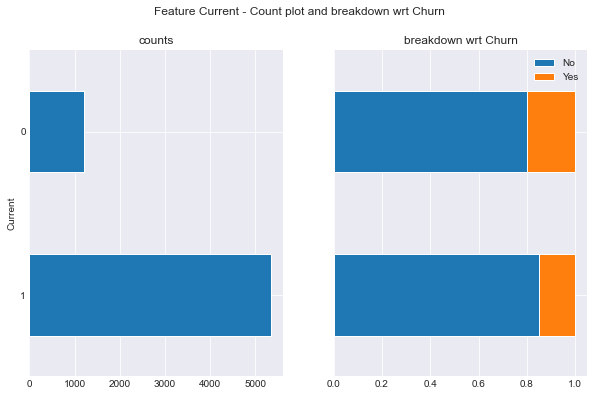

In [146]:
eda_cat(df_train,feature,target)

In [147]:
feature = 'Deposit'
df_train[feature] = pd.Categorical(df_train[feature].astype(str))
df_test[feature] = pd.Categorical(df_test[feature].astype(str))

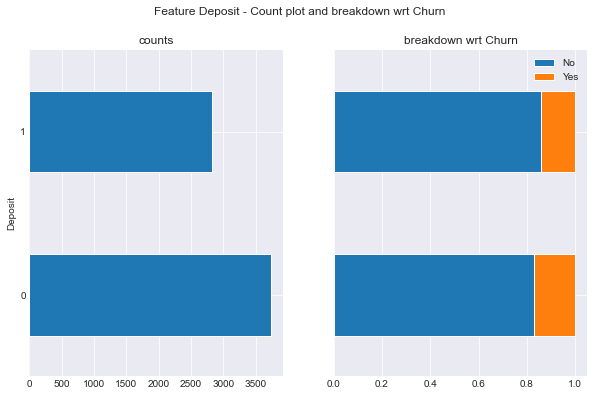

In [148]:
eda_cat(df_train,feature,target)

In [149]:
feature = 'Investment'
df_train[feature] = pd.Categorical(df_train[feature].astype(str))
df_test[feature] = pd.Categorical(df_test[feature].astype(str))

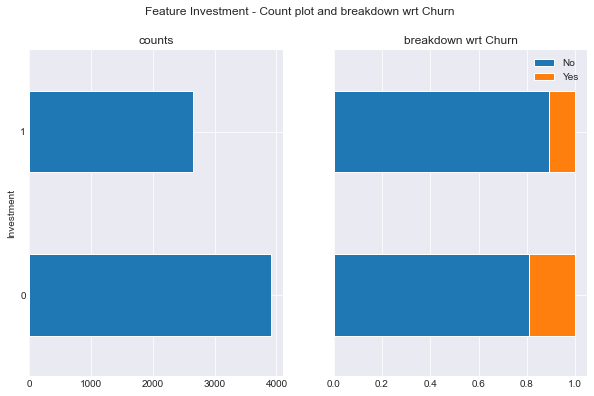

In [150]:
eda_cat(df_train,feature,target)

In [151]:
feature = 'Joint'
df_train[feature] = pd.Categorical(df_train[feature].astype(str))
df_test[feature] = pd.Categorical(df_test[feature].astype(str))

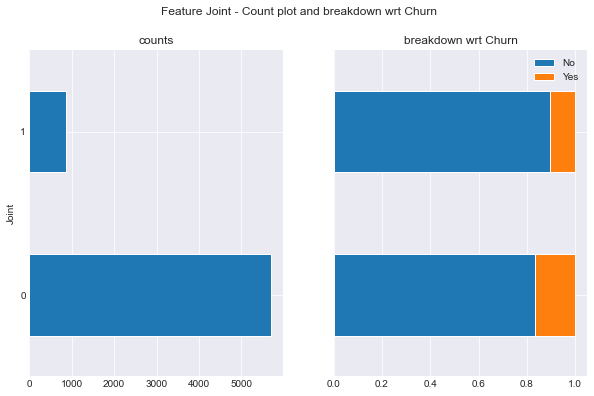

In [152]:
eda_cat(df_train,feature,target)

In [153]:
feature = 'Loan'
df_train[feature] = pd.Categorical(df_train[feature].astype(str))
df_test[feature] = pd.Categorical(df_test[feature].astype(str))

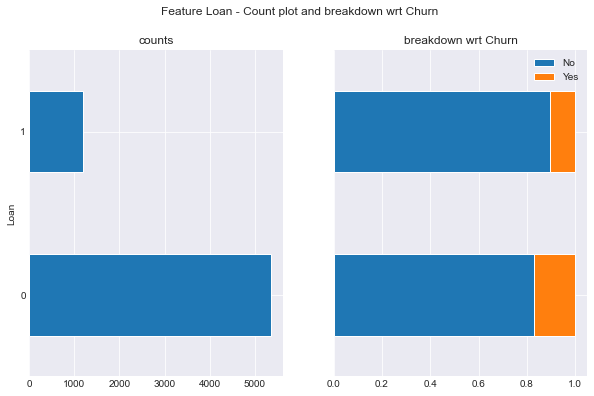

In [154]:
eda_cat(df_train,feature,target)

In [155]:
feature = 'Mortgage'
df_train[feature] = pd.Categorical(df_train[feature].astype(str))
df_test[feature] = pd.Categorical(df_test[feature].astype(str))

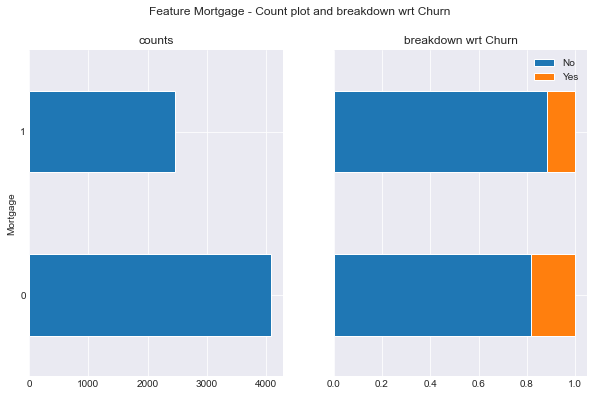

In [156]:
eda_cat(df_train,feature,target)

In [157]:
feature = 'On_Demand_Deposit'
df_train[feature] = pd.Categorical(df_train[feature].astype(str))
df_test[feature] = pd.Categorical(df_test[feature].astype(str))

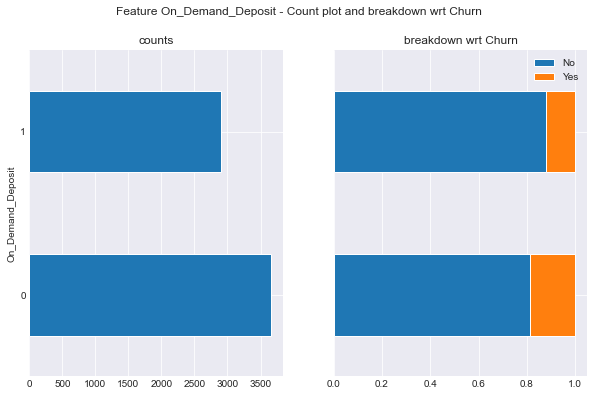

In [158]:
eda_cat(df_train,feature,target)

<AxesSubplot:xlabel='Churn', ylabel='Sum_Transaction'>

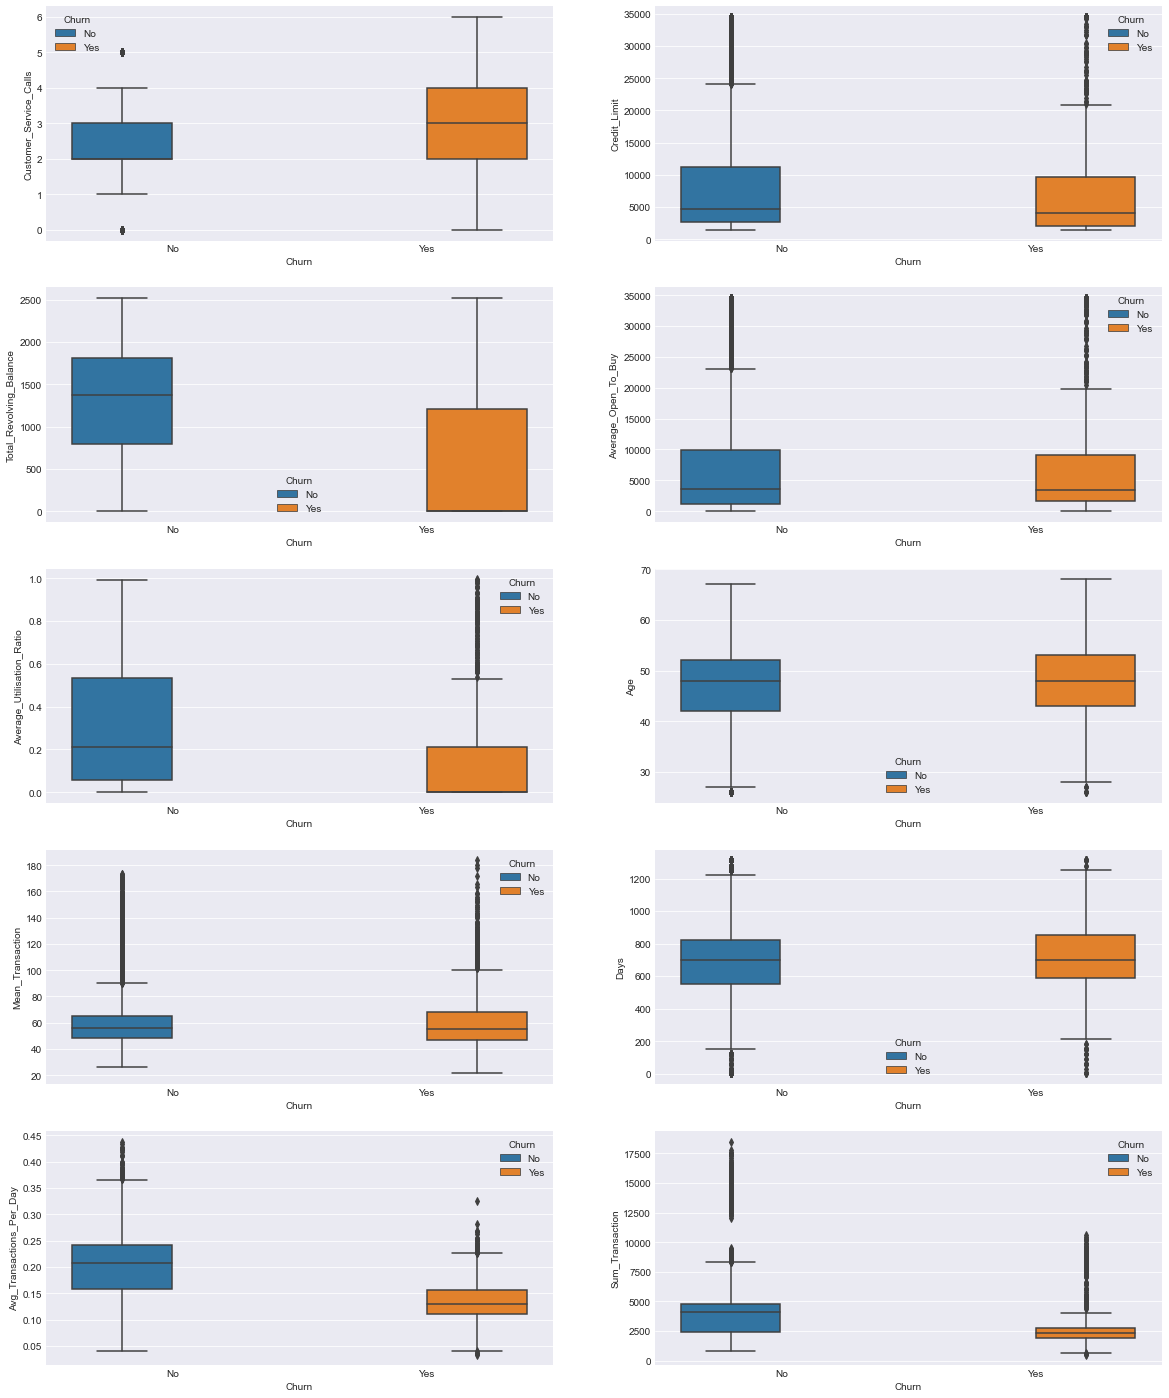

In [159]:
fig, axarr = plt.subplots(5, 2, figsize=(20, 25))
sns.boxplot(y='Customer_Service_Calls',x = target, hue = target,data = df_train, ax=axarr[0][0])
sns.boxplot(y='Credit_Limit',x = target, hue = target,data = df_train , ax=axarr[0][1])
sns.boxplot(y='Total_Revolving_Balance',x = target, hue = target,data = df_train, ax=axarr[1][0])
sns.boxplot(y='Average_Open_To_Buy',x = target, hue = target,data = df_train, ax=axarr[1][1])
sns.boxplot(y='Average_Utilisation_Ratio',x = target, hue = target,data = df_train, ax=axarr[2][0])
sns.boxplot(y='Age',x = target, hue = target,data = df_train, ax=axarr[2][1])
sns.boxplot(y='Mean_Transaction',x = target, hue = target,data = df_train, ax=axarr[3][0])
sns.boxplot(y='Days',x = target, hue = target,data = df_train , ax=axarr[3][1])
sns.boxplot(y='Avg_Transactions_Per_Day',x = target, hue = target,data = df_train, ax=axarr[4][0])
sns.boxplot(y='Sum_Transaction',x = target, hue = target,data = df_train, ax=axarr[4][1])

In [160]:
df_train['Revolving_Balance_given_age'] = df_train.Total_Revolving_Balance/(df_train.Age)
df_test['Revolving_Balance_given_age'] = df_test.Total_Revolving_Balance/(df_test.Age)

<AxesSubplot:xlabel='Churn', ylabel='Total_Revolving_Balance'>

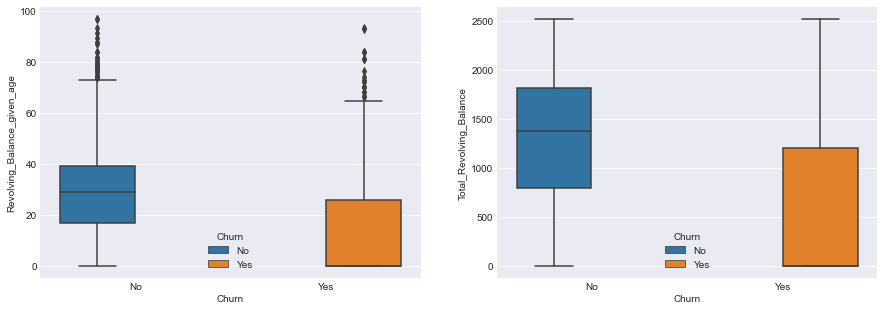

In [161]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(y='Revolving_Balance_given_age',x = target, hue = target,data = df_train, ax=axarr[0])
sns.boxplot(y='Total_Revolving_Balance',x = target, hue = target,data = df_train , ax=axarr[1])

In [162]:
df_train["Total_Utilised_Credit"] = df_train["Total_Revolving_Balance"] * df_train["Average_Utilisation_Ratio"]
df_test["Total_Utilised_Credit"] = df_test["Total_Revolving_Balance"] * df_test["Average_Utilisation_Ratio"]

<AxesSubplot:xlabel='Churn', ylabel='Total_Utilised_Credit'>

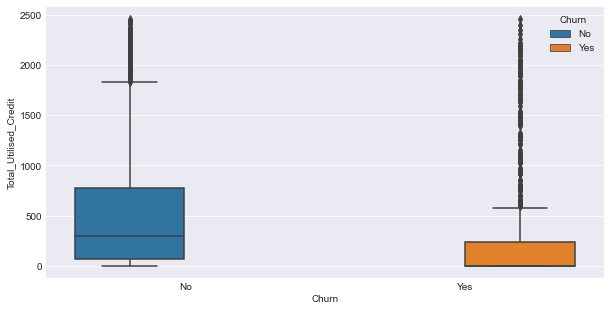

In [163]:
fig, axarr = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(y='Total_Utilised_Credit',x = target, hue = target,data = df_train)


In [164]:
df_train["Credit_Utilisation_Ratio"] = df_train["Total_Revolving_Balance"] / df_train["Credit_Limit"]
df_test["Credit_Utilisation_Ratio"] = df_test["Total_Revolving_Balance"] / df_test["Credit_Limit"]

<AxesSubplot:xlabel='Churn', ylabel='Credit_Utilisation_Ratio'>

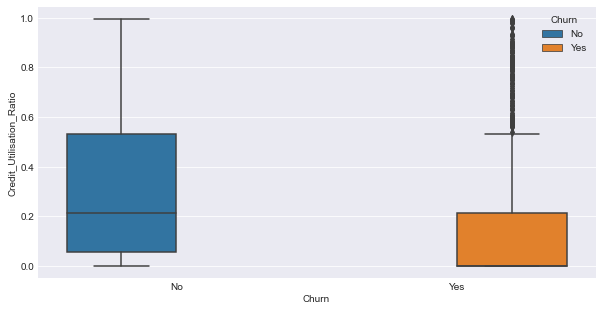

In [165]:
fig, axarr = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(y='Credit_Utilisation_Ratio',x = target, hue = target,data = df_train)

In [166]:
df_train['Service_Calls_to_Limit_Ratio'] = df_train['Customer_Service_Calls'] / df_train['Credit_Limit']
df_test['Service_Calls_to_Limit_Ratio'] = df_test['Customer_Service_Calls'] / df_test['Credit_Limit']

<AxesSubplot:xlabel='Churn', ylabel='Service_Calls_to_Limit_Ratio'>

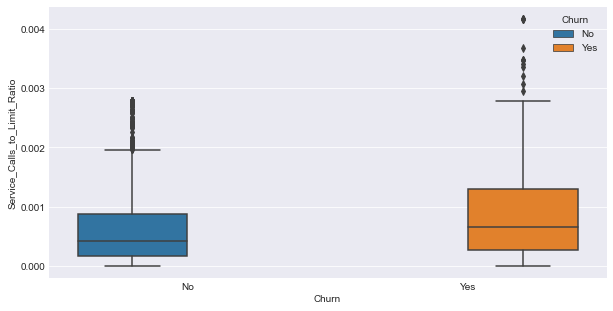

In [167]:
fig, axarr = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(y='Service_Calls_to_Limit_Ratio',x = target, hue = target,data = df_train)

In [168]:
print(df_train.shape, df_train.isna().sum().sum())
df_train.head()

(6556, 35) 0


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Days,Current,Deposit,Investment,Joint,Loan,Mortgage,On_Demand_Deposit,Days_Active,Transaction_Count,Avg_Transactions_Per_Day,Max_Transaction,Min_Transaction,Mean_Transaction,Std_Transaction,Sum_Transaction,Revolving_Balance_given_age,Total_Utilised_Credit,Credit_Utilisation_Ratio,Service_Calls_to_Limit_Ratio
0,797197508,No,0,2020-06-01,1,2315.0,1565.0,750.0,0.676,48,F,2,1,2,0,549.0,1,1,1,0,0,1,0,331,90,0.271903,342.82,8.59,53.644000,51.087679,4827.96,32.604167,1057.940,0.676026,0.000432
1,812854728,No,0,2020-01-01,1,7645.0,2076.0,5569.0,0.272,58,F,1,2,5,0,701.0,0,0,0,0,0,0,0,362,75,0.207182,1296.47,5.89,102.799600,181.396165,7709.97,35.793103,564.672,0.271550,0.000131
2,768000743,No,0,2020-01-01,2,6394.0,0.0,6394.0,0.000,55,F,1,2,2,0,701.0,1,0,0,0,0,0,0,332,69,0.207831,279.84,3.97,50.290725,52.551327,3470.06,0.000000,0.000,0.000000,0.000313
3,722161439,No,0,2020-08-01,3,4663.0,0.0,4663.0,0.000,41,F,2,1,2,1,488.0,1,1,1,0,1,1,0,327,81,0.247706,317.30,9.96,47.296420,50.063738,3831.01,0.000000,0.000,0.000000,0.000643
4,759029725,No,0,2021-02-01,4,1879.0,1486.0,393.0,0.791,37,F,1,2,1,0,304.0,1,1,1,0,0,1,0,359,88,0.245125,237.55,5.45,59.114091,60.445166,5202.04,40.162162,1175.426,0.790846,0.002129


In [169]:
print(df_test.shape, df_test.isna().sum().sum())
df_test.head()

(3542, 34) 0


,Customer,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,Days,Current,Deposit,Investment,Joint,Loan,Mortgage,On_Demand_Deposit,Days_Active,Transaction_Count,Avg_Transactions_Per_Day,Max_Transaction,Min_Transaction,Mean_Transaction,Std_Transaction,Sum_Transaction,Revolving_Balance_given_age,Total_Utilised_Credit,Credit_Utilisation_Ratio,Service_Calls_to_Limit_Ratio
0,774663629,1,2020-01-01,2,29663.0,1743.0,27920.0,0.059,51,M,2,2,3,2,701.0,1,1,0,0,0,0,0,358,93,0.259777,1176.28,10.82,157.397849,177.297431,14638.00,34.176471,102.837,0.058760,0.000067
1,720420396,0,2020-11-01,2,2032.0,1195.0,837.0,0.588,45,F,2,0,3,1,396.0,0,0,0,0,0,0,0,356,80,0.224719,399.76,3.28,55.987125,60.871741,4478.97,26.555556,702.660,0.588091,0.000984
2,815283379,0,2020-01-01,1,17268.0,1197.0,16071.0,0.069,57,M,2,2,3,4,701.0,1,0,0,0,0,0,0,356,90,0.252809,213.94,3.79,45.300111,46.328322,4077.01,21.000000,82.593,0.069319,0.000058
3,764861610,0,2020-05-01,3,2264.0,0.0,2264.0,0.000,38,F,0,2,2,0,580.0,1,1,1,0,1,0,0,338,28,0.082840,186.81,8.67,43.000714,44.238825,1204.02,0.000000,0.000,0.000000,0.001325
4,742798818,0,2020-01-01,1,2192.0,1464.0,728.0,0.668,45,F,3,1,4,0,701.0,0,1,0,1,1,1,1,361,89,0.246537,260.42,6.95,55.112697,55.664159,4905.03,32.533333,977.952,0.667883,0.000456


## Save Dataset

In [170]:
df_train.to_pickle(f"{ROOT}/data/df_train2.pkl")
df_test.to_pickle(f"{ROOT}/data/df_test2.pkl")